# Training model on Titanic Dataset

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
# Load the Titanic dataset
titanic = sns.load_dataset('titanic')

In [4]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
# Handling Missing Values
# Impute missing values in 'age' with the mean
imputer = SimpleImputer(strategy='mean')
titanic['age'] = imputer.fit_transform(titanic[['age']])

In [6]:
titanic['age'].isnull().sum()

np.int64(0)

In [7]:
# Assume 'deck' has too many missing values and drop it
titanic.drop(columns=['deck'], inplace=True)

In [8]:
titanic.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive',
       'alone'],
      dtype='object')

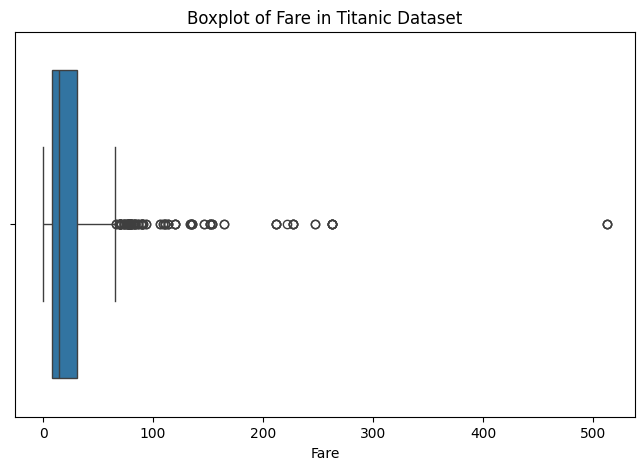

In [9]:
# Boxplot fare

# Create the boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=titanic['fare'])

# Add title and labels
plt.title('Boxplot of Fare in Titanic Dataset')
plt.xlabel('Fare')

# Show the plot
plt.show()

In [10]:
# Outlier Detection and Removal
# Detect and remove outliers in 'fare' based on the Interquartile Range (IQR)
Q1 = titanic['fare'].quantile(0.25)
Q3 = titanic['fare'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
titanic = titanic[(titanic['fare'] >= lower_bound) & (titanic['fare'] <= upper_bound)]

In [11]:
# Normalization
# Normalize 'fare' to have values between 0 and 1
scaler_min_max = MinMaxScaler()
titanic['fare_normalized'] = scaler_min_max.fit_transform(titanic[['fare']])

In [12]:
# Standardization
# Standardize 'age' to have a mean of 0 and a standard deviation of 1
scaler_std = StandardScaler()
titanic['age_standardized'] = scaler_std.fit_transform(titanic[['age']])

In [13]:
# Binning
# Transform 'age' into three discrete categories
titanic['age_binned'] = pd.cut(titanic['age'], bins=[0, 18, 60, 100], labels=["Child", "Adult", "Senior"])

In [14]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,fare_normalized,age_standardized,age_binned
0,0,3,male,22.000000,1,0,7.2500,S,Third,man,True,Southampton,no,False,0.111538,-0.556219,Adult
2,1,3,female,26.000000,0,0,7.9250,S,Third,woman,False,Southampton,yes,True,0.121923,-0.243027,Adult
3,1,1,female,35.000000,1,0,53.1000,S,First,woman,False,Southampton,yes,False,0.816923,0.461654,Adult
4,0,3,male,35.000000,0,0,8.0500,S,Third,man,True,Southampton,no,True,0.123846,0.461654,Adult
5,0,3,male,29.699118,0,0,8.4583,Q,Third,man,True,Queenstown,no,True,0.130128,0.046606,Adult


In [15]:
# Feature Engineering
# Create a new feature 'family_size' from 'sibsp' and 'parch'
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

In [16]:
# Feature Selection
# Select the top 3 features that have the highest correlation with 'survived'
X = titanic[['pclass', 'age', 'sibsp', 'parch', 'fare_normalized']]
y = titanic['survived']
selector = SelectKBest(score_func=chi2, k=3)
X_selected = selector.fit_transform(X, y)

In [17]:
# Encoding Categorical Variables
# Convert 'sex' into a numerical format using Label Encoding
label_encoder = LabelEncoder()
titanic['sex_encoded'] = label_encoder.fit_transform(titanic['sex'])

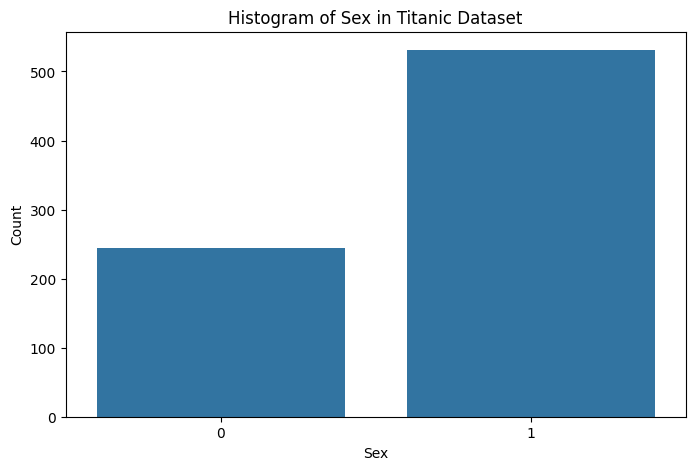

In [18]:
# Create a histogram for the 'sex' column
plt.figure(figsize=(8, 5))
sns.countplot(x=titanic['sex_encoded'])

# Add title and labels
plt.title('Histogram of Sex in Titanic Dataset')
plt.xlabel('Sex')
plt.ylabel('Count')

# Show the plot
plt.show()

In [19]:
# Convert 'embarked' into binary columns using One-Hot Encoding
one_hot_encoder = OneHotEncoder()
encoded_embarked = one_hot_encoder.fit_transform(titanic[['embarked']]).toarray()
embarked_columns = one_hot_encoder.get_feature_names_out(['embarked'])
titanic = titanic.join(pd.DataFrame(encoded_embarked, columns=embarked_columns))

In [20]:

# Data Splitting
# Split the data into training and testing sets
X = titanic[['pclass', 'sex_encoded', 'age_standardized', 'sibsp', 'parch', 'fare_normalized', 'family_size']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, the dataset is ready for model training

In [21]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    results[name] = accuracy  # Store results
    
    # Print performance
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

# Find the best model
best_model = max(results, key=results.get)
print(f"\nBest Model: {best_model} with Accuracy: {results[best_model]:.2f}")


Model: Random Forest
Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79        95
           1       0.67      0.58      0.62        60

    accuracy                           0.73       155
   macro avg       0.72      0.70      0.71       155
weighted avg       0.72      0.73      0.72       155

--------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83        95
           1       0.77      0.62      0.69        60

    accuracy                           0.78       155
   macro avg       0.78      0.75      0.76       155
weighted avg       0.78      0.78      0.77       155

--------------------------------------------------
Model: XGBoost
Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           